In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
import numpy as np
import os

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_dir = "./train"
test_dir = "./test"

IMG_SIZE = (128, 128) 
BATCH_SIZE = 32

In [3]:
train_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    validation_split=0.2,  # 20% de train se usa como validación
    subset="training",
    seed=123
) 

val_dataset = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    validation_split=0.2,  # 20% de train se usa como validación
    subset="validation",
    seed=123
)

test_dataset = keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

# Prepararmos un data augmentantion
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3), 
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2),
])

normalization_layer = layers.Rescaling(1./255)

def preprocess(image, label):
    image = data_augmentation(image)
    image = normalization_layer(image)
    return image, label

train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

Found 656 files belonging to 2 classes.
Using 525 files for training.
Found 656 files belonging to 2 classes.
Using 131 files for validation.
Found 160 files belonging to 2 classes.


In [4]:
model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [6]:
history = model.fit(train_dataset,validation_data=val_dataset,epochs=10)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.5486 - loss: 0.8265 - val_accuracy: 0.8702 - val_loss: 0.6567
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6937 - loss: 0.6347 - val_accuracy: 0.7176 - val_loss: 0.5179
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8089 - loss: 0.4616 - val_accuracy: 0.9389 - val_loss: 0.2232
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8826 - loss: 0.2956 - val_accuracy: 0.9237 - val_loss: 0.1705
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9177 - loss: 0.2378 - val_accuracy: 0.9389 - val_loss: 0.1682
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.9298 - loss: 0.1812 - val_accuracy: 0.9618 - val_loss: 0.1228
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.9246 - loss: 0.2087 - val_accuracy: 0.9389 - val_loss: 0.1752
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.9136 - loss: 0.2000 - val_accuracy: 0.9542 - val_loss:

In [7]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nPrecisión en test: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 510ms/step - accuracy: 0.9813 - loss: 0.0518

Precisión en test: 0.9688


In [8]:
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype("int32")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 556ms/step


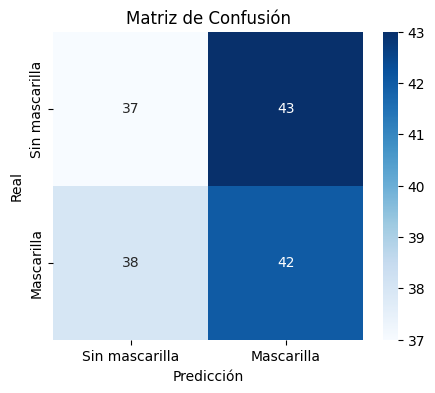

In [9]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Sin mascarilla", "Mascarilla"], yticklabels=["Sin mascarilla", "Mascarilla"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [11]:
print(classification_report(y_true, y_pred, target_names=["No Mascarilla", "Mascarilla"]))

               precision    recall  f1-score   support

No Mascarilla       0.49      0.46      0.48        80
   Mascarilla       0.49      0.53      0.51        80

     accuracy                           0.49       160
    macro avg       0.49      0.49      0.49       160
 weighted avg       0.49      0.49      0.49       160



In [23]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image

carpeta_imagenes = r"C:\imagenes_prueba_mascarilla"

for nombre_imagen in os.listdir(carpeta_imagenes):
    ruta_imagen = os.path.join(carpeta_imagenes, nombre_imagen)

    # Cargar y preparar la imagen
    img = image.load_img(ruta_imagen, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediccion = model.predict(img_array)

    if prediccion.shape[1] == 1:
        resultado = int(prediccion[0, 0] > 0.5)
    else:
        resultado = np.argmax(prediccion)

    clases = ["No Mascarilla", "Mascarilla"]
    print(f"Imagen: {nombre_imagen} → Clase Predicha: {clases[resultado]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Imagen: 1701.jpg → Clase Predicha: Mascarilla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Imagen: 1702.jpg → Clase Predicha: Mascarilla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Imagen: 1713.jpg → Clase Predicha: Mascarilla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Imagen: 1721.jpg → Clase Predicha: No Mascarilla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Imagen: 1727.jpg → Clase Predicha: Mascarilla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Imagen: 1731.jpg → Clase Predicha: No Mascarilla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Imagen: imagen_prueba_mascarilla1.jpg → Clase Predicha: Mascarilla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
Imagen: imagen_prueba_mascarilla2.jpg → Clase Predicha: No Mascarilla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Imagen: imagen_prueba_mascarilla3.jpg → Clase Predicha: Mascarilla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Imagen: imagen_prueba_mascarilla4.jpg → Clase Predicha: Mascarilla
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Imagen: real_00001.jpg → C